In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

sys.path.insert(0, '../')
#sys.path.insert(1, '/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages')
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.amplitude.romannet import ROMANAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux
from few.utils.overlap import get_overlap, get_mismatch

# Fast and Accurate EMRI Waveforms

Here we provide a set of examples for creating EMRI waveforms as a whole; looking at separate creation pieces (trajectory, amplitude, summation, etc.); and creating your own module to build directly into this framework. For details on the specifics of our waveforms like constructions used and generally methodology, we refer you to our paper (TODO: add arxiv) and the [package documentation](https://mikekatz04.github.io/FastEMRIWaveforms/). 

If you use any work from package please cite our paper (TODO: add arxiv). Additionally please cite any additional work for each module used by calling the `citation` attribute on the module class:

In [2]:
wave = FastSchwarzschildEccentricFlux()
print(wave.citation)


                Temp citation for this paper
                
                @article{Hughes:2005qb,
                    author = "Hughes, Scott A. and Drasco, Steve and Flanagan, Eanna E. and Franklin, Joel",
                    title = "{Gravitational radiation reaction and inspiral waveforms in the adiabatic limit}",
                    eprint = "gr-qc/0504015",
                    archivePrefix = "arXiv",
                    doi = "10.1103/PhysRevLett.94.221101",
                    journal = "Phys. Rev. Lett.",
                    volume = "94",
                    pages = "221101",
                    year = "2005"
                }
            

                @article{Chua:2018woh,
                    author = "Chua, Alvin J.K. and Galley, Chad R. and Vallisneri, Michele",
                    title = "{Reduced-order modeling with artificial neurons for gravitational-wave inference}",
                    eprint = "1811.05491",
                    archivePrefix = "arXiv",
    

## Full EMRI Waveforms

In the section, we will describe how to create EMRI waveforms with both our fast and slow EMRI waveform model. The current full models include [`FastSchwarzschildEccentricFlux`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.FastSchwarzschildEccentricFlux) and [`SlowSchwarzschildEccentricFlux`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.SlowSchwarzschildEccentricFlux). These are fast and slow versions of models that evolve eccentric flux-based trajectories in a Schwarzschild background. The fast model can be run exactly as shown here on CPUs or GPUs by providing the correct initialization arguments. 

The waveform model produces $h(t) = h_p - ih_c(t) $. It takes as arguments $\{M, \mu, p_0, e_0, \Phi_{\phi,0}, \Phi_{r, 0}\}$. $M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity, and the final two are the initial phases in $\phi, r$.

### [FastSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.FastSchwarzschildEccentricFlux)

The fast waveform generates sparse trajectories with ~100 points. Amplitudes for all modes are then determined with ROMAN network. From these amplitudes, we perform mode selection to remove modes that do not contribute significantly to the waveform. The remaining modes and phases are then interpolated with cubic splines. In one final step, the amplitude, phase, and angular harmonic information is then combined with an interpolated summation. 

* Trajectory Module: [`RunSchwarzEccFluxInspiral`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.trajectory.flux.RunSchwarzEccFluxInspiral)

* Amplitude Module: [`ROMANAmplitude`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.amplitude.romannet.ROMANAmplitude)

* Summation Module: [`InterpolateModeSum`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.summation.interpolatedmodesum.InterpolatedModeSum)

* Mode Selection: [`ModeSelector`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.utils.modeselector.ModeSelector)

* Angular Harmonics: [`GetYlms`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.utils.ylm.GetYlms)


In [2]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (ROMANAmplitude)
amplitude_kwargs = {
    "max_input_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu  # GPU is availabel for this type of summation
}

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [3]:
# parameters
M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle

wave = few(M, mu, p0, e0, theta, phi)  #  assumes dt = 10.0 for max T = 1.0 year

KeyboardInterrupt: 

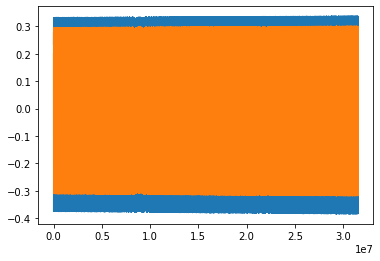

In [4]:
dt = 10.0
t = np.arange(len(wave)) * dt

plt.plot(t, wave.real)
plt.plot(t, wave.imag)

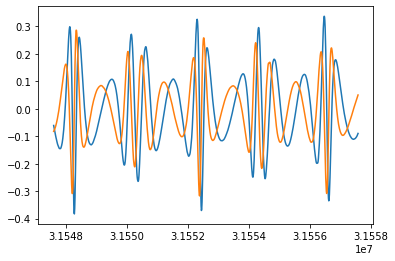

In [9]:
plt.plot(t[-1000:], wave.real[-1000:])
plt.plot(t[-1000:], wave.imag[-1000:])

To get shorter waveforms, you can provide the `T` kwarg for the function call. This is the observation time in years. You can also adjust `dt`. This is the time change in samples in seconds.

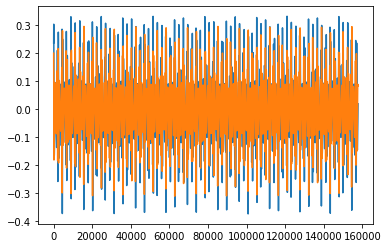

In [3]:
# parameters
M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle

dt = 15.0 # seconds
T = 0.005  # years
wave = few(M, mu, p0, e0, theta, phi, T=T, dt=dt)

# we can check how many harmonic modes are kept

t = np.arange(len(wave))*dt
plt.plot(t, wave.real)
plt.plot(t, wave.imag)

The `eps` kwarg will change the mode content of the waveform. Lowering it add modes. Increasing it will remove modes. The default is $10^{-5}$. This is generally recommended as good setting for good overlaps across the available parameter space.

wave used 582 modes. wave2 used 45 modes. The mismatch was 0.002291901524509421


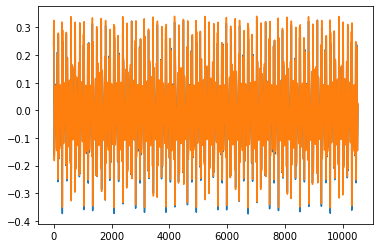

In [16]:
dt = 15.0 # seconds
T = 0.005  # years
wave1 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-5)  # default

# we can check how many harmonic modes are kept
modes1 = few.num_modes_kept

wave2 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-2)

modes2 = few.num_modes_kept

plt.plot(wave1.real, label=r'$10^{-2}$')
plt.plot(wave2.real, label=r'$10^{-2}$')

# we can also compute the mismatch when removing modes
mm = get_mismatch(wave, wave2)

# we can check how many modes were kept
print('wave used {} modes. wave2 used {} modes. The mismatch was {}'.format(modes1, modes2, mm))

### [SlowSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.SlowSchwarzschildEccentricFlux)

The slow waveform generates dense trajectories with at every `dt` seconds within `T` years. Amplitudes for all modes are then determined with a 2d bicubic spline over semi-latus rectum and eccentricity for each mode. This is done at each dense time step. We do not perform mode selection because this is the slow and most accurate model against which we compare the fast model. The final summation is a direct combination of phase, amplitude, and Ylm information at each dense timestep. 

**Note**: One thing to pay attention to with the slow waveform is batch size. This is determined by memory limits. Usually anything under ~10000 is fine.

* Trajectory Module: [`RunSchwarzEccFluxInspiral`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.trajectory.flux.RunSchwarzEccFluxInspiral)

* Amplitude Module: [`Interp2DAmplitude`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.amplitude.interp2dcubicspline.Interp2DAmplitude)

* Summation Module: [`DirectModeSum`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.summation.directmodesum.DirectModeSum)

* Mode Selection: None

* Angular Harmonics: [`GetYlms`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.utils.ylm.GetYlms)


In [5]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 1,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e7),  # dense stepping trajectories
    }

# keyword arguments for inspiral generator (ROMANAmplitude)
amplitude_kwargs = {
    "max_input_len": int(1e4),  # this must be >= batch_size
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu  # GPU is availabel for this type of summation
}

slow = SlowSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

# parameters
T = 0.005  # years
dt = 15.0 # seconds
M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
batch_size = int(1e4)

slow_wave = slow(M, mu, p0, e0, theta, phi, T=T, dt=dt, batch_size=batch_size)

Mismatch: 2.7310255063084377e-05


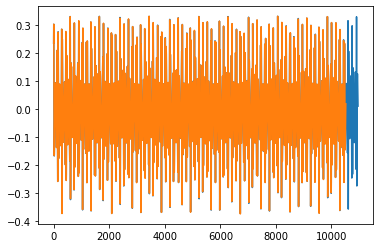

In [6]:
fast_wave = few(M, mu, p0, e0, theta, phi, T=T, dt=dt)

plt.plot(slow_wave.real)
plt.plot(fast_wave.real)
print('Mismatch:', get_mismatch(slow_wave, fast_wave))

## Trajectory Module

The trajectory module generates orbital and phase trajectories, $G(t)$, for an EMRI orbit:  

\begin{equation}
    G(t) = \{p(t), e(t), \iota(t), \Phi_\phi(t), \Phi_\theta(t), \Phi_r(t)\}
\end{equation}

with inputs $M, \mu, p_0, e_0, \iota_0, \Phi_{\phi,0}, \Phi_{\theta,0}, \Phi_{r, 0}$. $M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity, and the final three are the initial phases in $\phi, \theta, r$. When working in equatorial orbits, $\iota(t)$ and $\Phi_\theta(t)$ are zero. The trajectory module also produces the gravitational wave flux for normalization information.

### Run a basic trajectory

In [6]:
# initialize trajectory class
traj = RunSchwarzEccFluxInspiral()

In [7]:
# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

# run trajectory
t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)

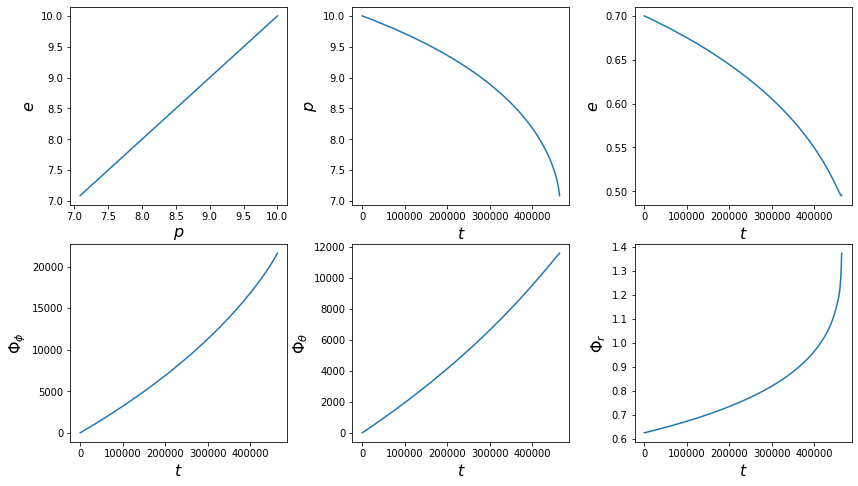

In [8]:
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_\theta$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [p, p, e, Phi_phi, Phi_r, flux]
xs = [p, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

### Defining a new t vector

../few/utils/baseclasses.py:268: UserWarning: new_t array goes beyond generated t array. If you want to cut the t array at the end of the trajectory, set fix_t to True.
  "new_t array goes beyond generated t array. If you want to cut the t array at the end of the trajectory, set fix_t to True."


t1 max: 999999.0 t2 max: 464407.0


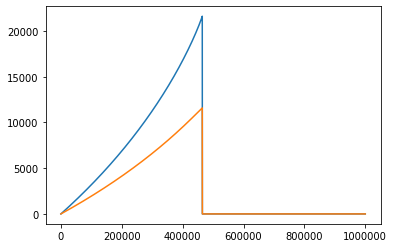

In [15]:
new_t = np.arange(0, 1e6, 1.0) 

# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

# a warning will be thrown if the new_t array goes beyond the time array output from the trajectory
t1, p1, e1, Phi_phi1, Phi_r1, flux1 = traj(M, mu, p0, e0, new_t=new_t, upsample=True)

# you can cut the excess on these arrays by setting fix_t to True
t2, p2, e2, Phi_phi2, Phi_r2, flux2 = traj(M, mu, p0, e0, new_t=new_t, upsample=True, fix_t=True)

plt.plot(t1, Phi_phi1, label=r'$\Phi_\phi$')
plt.plot(t1, Phi_r1, label=r'$\Phi_r$')

print('t1 max:', t1.max(), 't2 max:', t2.max())


### Defining dt and T

/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


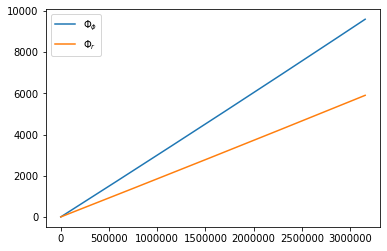

In [17]:
dt = 15.0
T = 0.1 # years

# set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0, dt=dt, T=T, upsample=True)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()

### Getting dimensionless time ($t/M$)

Dimensionless time step: 20.30254435170025


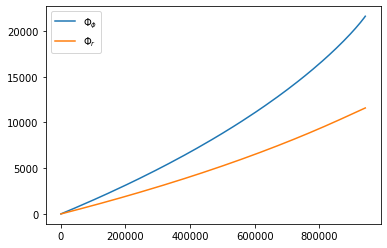

In [9]:
# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0, in_coordinate_time=False)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()
print('Dimensionless time step:', t[1] - t[0])

### Dense Stepping

In [4]:
# initialize trajectory class
dense_traj = RunSchwarzEccFluxInspiral(DENSE_STEPPING=1, max_input_len=int(1e7))

In [5]:
dt = 15.0
T = 0.1 # years

# set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, Phi_phi, Phi_r, flux = dense_traj(M, mu, p0, e0, dt=dt, T=T, upsample=True)

In [6]:
t

array([0.000000e+00, 1.500000e+01, 3.000000e+01, ..., 3.155730e+06,
       3.155745e+06, 3.155760e+06])

## Amplitude Module

The amplitude module generates the complex mode amplitudes for each harmonic mode requested, $A_{lmkn}(t)$ ($k=0$ for equatorial orbits). With Schwarzschild eccentric amplitudes, the user provides $p$ and $e$ as arrays and is returned the requested Teukolsky modes in a 2D array of shape (trajectory length, number of modes). 

### ROMAN amplitude generation

ROMAN uses a reduced order model representing the mode amplitude space. It then trains a neural network on this reduced model. The neural network is evaluated and the resulting matrix is transformed from the reduced basis back to the full mode space.  

In [6]:
# initialize ROMAN class
amp = ROMANAmplitude(max_input_len=5000)  # max_input_len creates memory buffers

Total trajectory points: 2500


Text(0, 0.5, 'e')

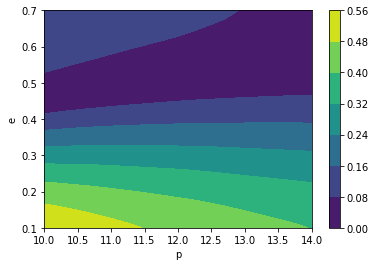

In [8]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])

print('Total trajectory points:', p_all.shape[0])
teuk_modes = amp(p_all, e_all)

# look at the contours of the (2,2,0) mode
cb = plt.contourf(p, e, np.abs(teuk_modes[:, amp.special_index_map[(2,2,0)]].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

Specific modes can be selected by providing a list of tuple of (l,m,n) values as the `specific_modes` kwarg:

Indices of interest: [ 640 1922]
False
False


Text(0, 0.5, 'e')

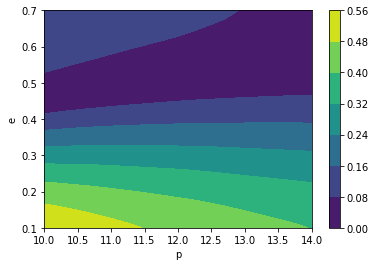

In [7]:
# (2, 2, 0) and (7, -3, 1) modes
specific_modes = [(2, 2, 0), (7, -3, 1)]

# notice this returns a dictionary with keys as the mode tuple and values as the mode values at all trajectory points
specific_teuk_modes = amp(p_all, e_all, specific_modes=specific_modes)

# we can find the index to these modes to check
inds = np.array([amp.special_index_map[lmn] for lmn in specific_modes])
print('Indices of interest:', inds)

# make sure they are the same
print(np.allclose(specific_teuk_modes[(2, 2, 0)], teuk_modes[:, inds[0]]))

# to check -m modes we need to take the conjugate
print(np.allclose(specific_teuk_modes[(7, -3, 1)], np.conj(teuk_modes[:, inds[1]])))

# look at the contours of the (220)mode
cb = plt.contourf(p, e, np.abs(specific_teuk_modes[(2, 2, 0)].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

### Interpolate Modes with bicubic spline

For this amplitude generator, amplitudes are interpolated in 2D ($p$ and $e$) using bicubic splines. They are then evaluated for the desired modes. This is used to produce our slow waveform. This will also not scale well with dimensionality. **Note**: Specific modes can be selected in the same way as above.

In [2]:
# initialize class
amp2 = Interp2DAmplitude() 

Total trajectory points: 2500


Text(0, 0.5, 'e')

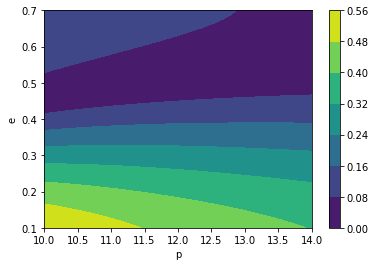

In [3]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])

print('Total trajectory points:', p_all.shape[0])

# to get all modes we can simply do this
teuk_modes = amp2(p_all, e_all)

# look at the contours of the (220) mode
cb = plt.contourf(p, e, np.abs(teuk_modes[:, amp2.special_index_map[(2,2,0)]].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')